In [0]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
#hosted on colab

In [0]:
x=np.array([12,123,32,5,4,3,5,67])
y=np.array([11,133,22,5,2,1,5,44])
pearsonr(x,y) #returns (corr,p-value of the 2 tailed test)

(0.9771274513188724, 2.9403813332491067e-05)

In [0]:
#function that returns rolling correlations
def roll_corr(x,y,length=5):
  corr=[]
  x_len=len(x)
  if (x_len!=len(y)):
    raise ValueError('Length of datasets do not match')
    return
  if (length>x_len):
    raise ValueError('Length of rolling window exceeds data')
    return
  for i in range(x_len):
    if (i+length>=x_len):
      break
    temp=pearsonr(x[i:i+length],y[i:i+length])[0]
    corr.append(temp)
  return corr

In [0]:
#example of above function
roll_corr(x,y,4)

[0.9953771854549682,
 0.9956629841931625,
 0.9929078162734514,
 0.9710607611177228]

In [0]:
'''
Class for creating a data environment. Input a list of urls, list of date type and list of date formats
List of url refers to a list of the urls of the raw data
List of data type should be comprised of 0 and 1s and should correspond to each url. 0 refers to equities data, 1 refers to other data
Equity data should have Date, High and Low columns
Other data should have Date and Value columns
List of date formats refers to the formats of the data in the Date column. 
If not necessary, please enter a ''. Otherwise enter the date format. This is the same as strptime format codes

Upon execution, the data is imported, cleaned and stored in the class.
'''
class data_environment(object):
  def __init__(self,url_list,data_type,date_format):

    self.check_inputs(url_list,data_type,date_format)
    self.init_data(url_list) 
    self.preprocess_data()

  def check_inputs(self,url_list,data_type,date_format): 
    if (len(url_list)!=len(data_type) or len(url_list)!=len(date_format)):
      raise ValueError('Diff lengths of url and data type obtained')
    temp=data_type.copy()
    temp=list(dict.fromkeys(temp))
    temp.sort()
    if (any(i!=0 and i!=1 for i in temp)):
      raise ValueError('Invalid data type input')  
    self.data_type=data_type
    self.date_format=date_format
            
  def init_data(self,url_list): 
    self.raw_data=[]
    for i in range(len(url_list)):
      temp=pd.read_csv(url_list[i]).dropna()
      temp=temp.reset_index()
      self.raw_data.append(temp)  

  def get_daily_price(self,data): 
    return data.loc[:,['High','Low']].mean(axis=1).values

  def get_logr(self,data):
    returns=data[1:]/data[:-1]
    return pd.Series(np.log(returns)).rename('Log-return')

  def get_datetime(self,data,i):
    if i=='':
      date=pd.to_datetime(data.Date)
    else:
      date=pd.to_datetime(data.Date,format=self.date_format[i],exact=False)
    return date     

  def preprocess_data(self): 
    self.data=[]
    for i in range(len(self.raw_data)):
      if (self.data_type[i]==0):
        date=self.get_datetime(self.raw_data[i],i)
        logr=self.get_logr(self.get_daily_price(self.raw_data[i]))
        self.data.append(pd.concat([date,logr],axis=1))
      else:
        date=self.get_datetime(self.raw_data[i],i)
        logr=self.get_logr(self.raw_data[i].loc[:,'Value'].values)
        self.data.append(pd.concat([date,logr],axis=1))

  def merge_download_all(self,join_style='outer'):
    temp=self.data[0]
    for i in range(1,len(self.data)):
      temp=pd.merge(temp,self.data[i],on='Date',how=join_style,sort=True)
    temp.to_csv('data.csv')
    files.download('data.csv')        

In [0]:
#Test all data. This is done by writing a list of all the links, a list of the data types 0,1 and a list of the date formats

sp500_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/%5EGSPC.csv'
yields_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/%5ETNX.csv'
gdp_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/UK_GDP_data.csv'
inflation_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/UK_inflation_data.csv'

test_url=[sp500_link,yields_link,gdp_link,inflation_link]
data_type=[0,0,1,1]
date_format=['','','%Y','%b-%y']

#creation of our data environment
data_env=data_environment(test_url,data_type,date_format)

In [0]:
data_env.merge_download_all(join_style='outer')

In [0]:
data_env.data[1].tail(10)

,Date,Log-return
7486,2020-01-10,0.003527
7487,2020-01-13,-0.007067
7488,2020-01-14,-0.023180
7489,2020-01-15,0.005013
7490,2020-01-16,0.018167
7491,2020-01-17,-0.028498
7492,2020-01-21,-0.005347
7493,2020-01-22,-0.021966
7494,2020-01-23,-0.016871
7495,2020-01-24,NaN


In [0]:
#consolidating our data, in this case with yield and inflation data
df=pd.merge(data_env.data[1],data_env.data[2],on='Date',how='outer')
#df=df.dropna()
df

,Date,Log-return_x,Log-return_y
0,1990-01-29,0.001176,NaN
1,1990-01-30,-0.009445,NaN
2,1990-01-31,-0.001187,NaN
3,1990-02-01,0.009456,NaN
4,1990-02-02,NaN,NaN
...,...,...,...
9310,2014-01-01,NaN,0.023284
9311,2015-01-01,NaN,0.019000
9312,2016-01-01,NaN,0.018744
9313,2018-01-01,NaN,NaN


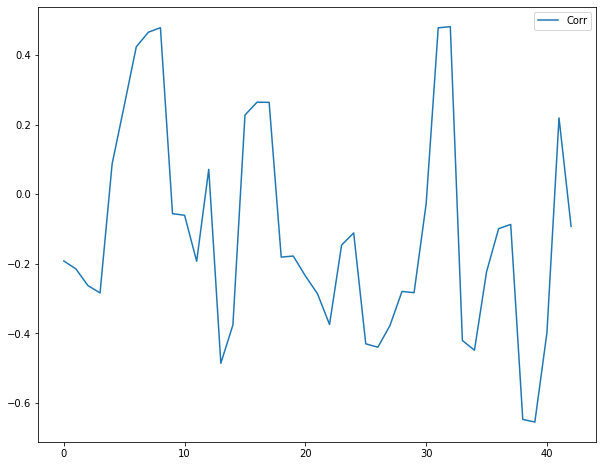

In [0]:
#plotting rolling correlations of 100 days or 20 weeks
corr_data=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,10)
plt.figure(figsize=[10,8])
plt.plot(corr_data,label="Corr")
plt.legend()
plt.show()

In [0]:
#run rolling correlation windows, from length 4 to 20,(1 year is 200)
#from the correlation data calculated, obtain first 4 central moments
from scipy.stats import skew
from scipy.stats import kurtosis
corr_data=pd.DataFrame(columns=['window_length','mean','var','skew','kurtosis'])
for i in range(4,20):
  values=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,i)
  entry_dict={'window_length':i,
              'mean':np.mean(values),
              'var':np.var(values),
              'skew':skew(values),
              'kurtosis':kurtosis(values)}
  corr_data=corr_data.append(entry_dict,ignore_index=True)
  print(i)

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


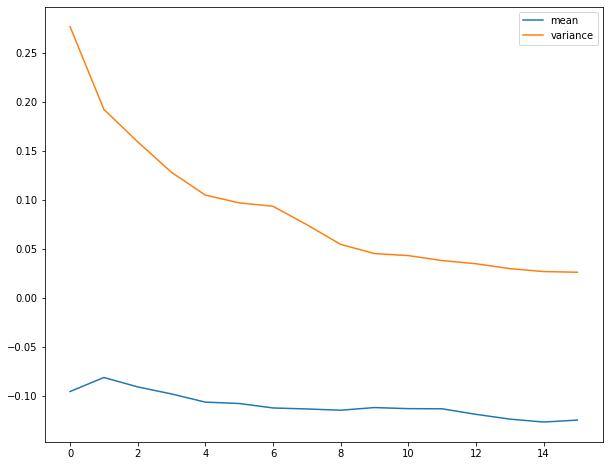

In [0]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'mean'],label='mean')
plt.plot(corr_data.loc[:,'var'],label='variance')
plt.legend()
plt.show()

Can observe variance steadily decreasing, as expected

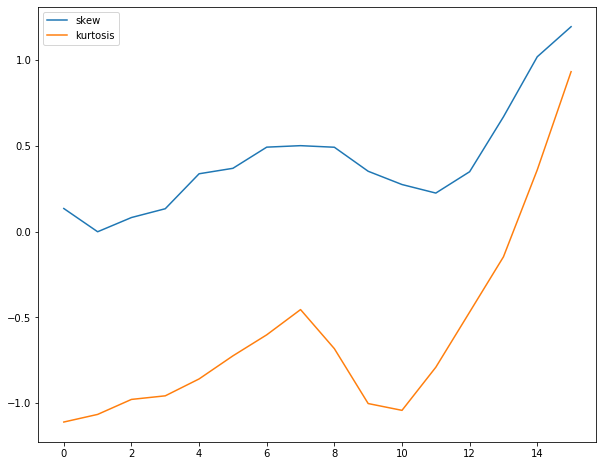

In [0]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'skew'],label='skew')
plt.plot(corr_data.loc[:,'kurtosis'],label='kurtosis')
plt.legend()
plt.show()